### ASSIST tests: Out-and-back integrations

Here we use ASSIST to carry out a series of out-and-back integrations of the orbit of the main belt asteroid (3666) Holman and the NEO Apophis.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ctypes
import importlib

import spiceypy as spice

import pkg_resources
import sys
sys.path.append(r'/Users/mholman/assist')
import assist

jd_ref = spice.j2000()

plt.rc('text', usetex = True)


In [2]:
# This cell defines the initial conditions we have used for the term-by-term comparison with Davide's
# version of JPL's code.
# The dynamical state available on Horizons now will be slightly different because additional
# observations have been incorporated into the orbital solution.
#
# DE441
# (3666) Holman
#2458849.500000000 = A.D. 2020-Jan-01 00:00:00.0000 TDB [del_T=     69.183900 s]
# X = 3.338875350265349E+00 Y =-9.176518267602161E-01 Z =-5.038590677470149E-01
# VX= 2.805663315227095E-03 VY= 7.550408688437705E-03 VZ= 2.980028207454247E-03

# We had used slightly different initial conditions for the term-by-term comparison with
# Davide's code.

#row = [3.338875348598862E+00, -9.176518412197102E-01, -5.038590741719294E-01,
#     2.805663364339457E-03, 7.550408665778840E-03, 2.980028207875623E-03]
# From email with Davide
row = [3.3388753502614090e+00, -9.1765182678903168e-01, -5.0385906775843303e-01,
     2.8056633153049852e-03,  7.5504086883996860e-03,  2.9800282074358684e-03]

In [3]:
# Here we are integrating out and back and then comparing to the initial conditions.  A perfect
# (or reversible) integration would exactly reproduce the initial conditions.   IAS15
# is not reversible, so this is a good test.

# We output both GR calculations for this comparison, but we only accumulate one of them.

# Full GR
# direct n-body accelerations, computed in ephemeris order.
# Earth J2, J3, and J4
# Solar J2

# We are turning off the term-by-term output to speed up the run.

tstart, tstep, trange = 2458849.5-jd_ref, 20.0, 1000

instates = np.array([row])

def round_trip(instates, tstart, tstep, trange):
    states = None
    epoch = tstart
    tend = tstart + trange
    n_particles = 1

    part_params = None
    #part_params = np.array([[2.790193367004E-7, 1.441264152527E-8, 1.573922634125E-8]])
    #part_params = np.array([[0.0, 1e-10, 0.0],[0.0, 2e-10, 0.0]])
    #part_params = np.array([[0.0, 0.0, 1e-10],[0.0, 0.0, 2e-10]])
    geocentric = 0

    n_var = 1

    invar_part = np.zeros(0, dtype=int)
    invar = np.zeros((1, 6))
    #var_part_params = np.array([1., 1., 1.])
    var_part_params = None
    #var_part_params = np.array([0., 1., 0.])
    #var_part_params = np.array([0., 0., 1.])

    nsubsteps = 10
    hg = np.arange(0, 1.1, 0.1, dtype=np.double)

    times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                       n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                       nsubsteps=nsubsteps)
    
    tstart, tstep, trange = tstart+trange, -tstep, -trange

    epoch = tstart
    tend = tstart + trange

    instates = states[-1].copy()
    n_particles = 1

    invar_part = np.zeros(0, dtype=int)
    invar = np.zeros((1, 6))
    var_part_params = np.array([1., 0., 0.])
    var_part_params = None
    
    del times
    del states

    times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                           n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                           nsubsteps=nsubsteps)
    
    return states[-1]


#(states[:,1,:]-states[:,0,:])[-1]-(var*1e-10)[-1]

In [4]:
# This is collecting the data for the round trip integration error analysis.  For
# a range of integration intervals, we determine the difference between the initial
# position and the final position after integrating out and back.  This particular
# experiment is for asteroid Holman with the standard initial conditions.

tstart, tstep = 2458849.5-jd_ref, 20.0

instates = np.array([row])

results=[]
for trange in np.logspace(0, 5, num=20):
    print(trange)
    results.append((trange, (round_trip(instates, tstart, tstep, trange)-instates)*1.5e8))

1.0
1.8329807108324359
3.3598182862837818
6.158482110660264
11.28837891684689
20.69138081114789
37.926901907322495
69.51927961775606
127.42749857031335
233.57214690901213
428.1332398719391
784.7599703514607
1438.449888287663
2636.650898730358
4832.930238571752
8858.667904100823
16237.76739188721
29763.51441631319
54555.947811685146
100000.0


In [5]:
t = list(map(lambda x: x[0], results))
dx = list(map(lambda x: np.linalg.norm(x[1][0][0:3]), results))

t = np.array(t)

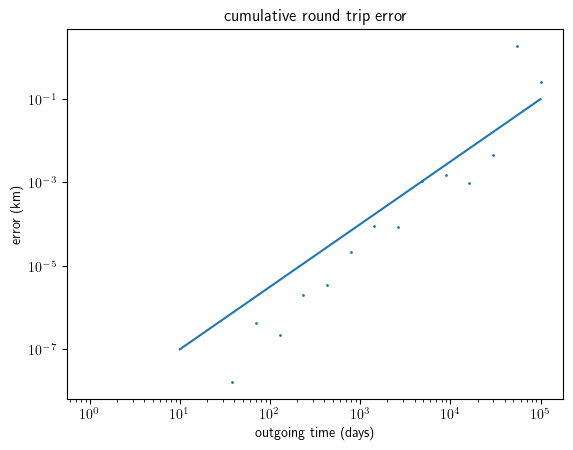

In [7]:
plt.scatter(t[:], dx[:], s=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('outgoing time (days)')
plt.ylabel('error (km)')
plt.title('cumulative round trip error')
plt.plot((1e1,1e5), (1e-7,1e-1))
plt.savefig('roundtrip_Holman.pdf')